<a href="https://colab.research.google.com/github/efgarcia-ut/aih-hrp/blob/main/High_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rtdl_num_embeddings

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [49]:
import random
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from google.colab import auth
from google.cloud import bigquery

from tqdm import tqdm, trange

from tabm_reference import Model, make_parameter_groups


auth.authenticate_user()
bq_client = bigquery.Client(project='utaih-449518')

In [ ]:
query = """
SELECT
  a.hadm_id,
  CASE
    WHEN p.gender = 'M' THEN 1
    ELSE 0
END
  AS gender,
  p.anchor_age + DATE_DIFF( a.admittime, DATE(p.anchor_year, 1, 1), YEAR ) AS age,
  TIMESTAMP_DIFF(a.dischtime, a.admittime, MINUTE) / 1440.0 AS length_of_admission,
FROM
  `physionet-data.mimiciv_3_1_hosp.admissions` a
JOIN
  `physionet-data.mimiciv_3_1_hosp.patients` p
ON
  a.subject_id = p.subject_id
WHERE
  a.hospital_expire_flag = 0
"""

admissions = bq_client.query(query).to_dataframe().set_index('hadm_id')
admissions = admissions[(admissions.age < 90)]
admissions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 512722 entries, 28525813 to 21106593
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               512722 non-null  Int64  
 1   age                  512722 non-null  Int64  
 2   length_of_admission  512722 non-null  float64
dtypes: Int64(2), float64(1)
memory usage: 17.1 MB


In [ ]:
query = """
SELECT
  a.hadm_id,
  p.gender,
  a.insurance,
  a.language,
  a.marital_status,
  a.race,
  p.anchor_age + DATE_DIFF( a.admittime, DATE(p.anchor_year, 1, 1), YEAR ) AS age,
  TIMESTAMP_DIFF(a.dischtime, a.admittime, MINUTE) / 1440.0 AS length_of_admission,
FROM
  `physionet-data.mimiciv_3_1_hosp.admissions` a
JOIN
  `physionet-data.mimiciv_3_1_hosp.patients` p
ON
  a.subject_id = p.subject_id
WHERE
  a.hospital_expire_flag = 0
"""

admissions = bq_client.query(query).to_dataframe().set_index('hadm_id')
admissions = admissions[(admissions.age < 90)]
admissions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 512722 entries, 28525813 to 21106593
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               512722 non-null  object 
 1   insurance            503763 non-null  object 
 2   language             512113 non-null  object 
 3   marital_status       501367 non-null  object 
 4   race                 512722 non-null  object 
 5   age                  512722 non-null  Int64  
 6   length_of_admission  512722 non-null  float64
dtypes: Int64(1), float64(1), object(5)
memory usage: 32.3+ MB


In [ ]:
query = """
SELECT
  itemid,
  label
FROM `physionet-data.mimiciv_3_1_hosp.d_labitems`
"""
lab_labels = bq_client.query(query).to_dataframe().set_index('itemid')['label']

lab_limit = 20
query = f"""
SELECT
  hadm_id,
  itemid,
  valuenum
FROM
  `physionet-data.mimiciv_3_1_hosp.labevents`
WHERE
  valuenum IS NOT NULL
  AND hadm_id IS NOT NULL
  AND itemid IN (
  SELECT
    itemid
  FROM
    `physionet-data.mimiciv_3_1_hosp.labevents`
  WHERE
    valuenum IS NOT NULL
    AND hadm_id IS NOT NULL
  GROUP BY
    itemid
  ORDER BY
    COUNT(DISTINCT hadm_id) DESC
  LIMIT
    {lab_limit} )
"""
lab_avg = (
    bq_client.query(query)
    .to_dataframe()
    .pivot_table(index=["hadm_id"], columns="itemid", values="valuenum", aggfunc="mean")
    .rename(columns=lab_labels)
)

lab_avg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 437901 entries, 20000019 to 29999935
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Anion Gap          406860 non-null  float64
 1   Bicarbonate        406895 non-null  float64
 2   Calcium, Total     372093 non-null  float64
 3   Chloride           409326 non-null  float64
 4   Creatinine         415833 non-null  float64
 5   Glucose            406252 non-null  float64
 6   Magnesium          379117 non-null  float64
 7   Phosphate          369575 non-null  float64
 8   Potassium          411533 non-null  float64
 9   Sodium             409795 non-null  float64
 10  Urea Nitrogen      411868 non-null  float64
 11  Hematocrit         430556 non-null  float64
 12  Hemoglobin         422276 non-null  float64
 13  MCH                421286 non-null  float64
 14  MCHC               421297 non-null  float64
 15  MCV                421292 non-null  float64
 16

In [ ]:
vitals_itemids = (
    220045, # Heart Rate,
    220179, # Non Invasive Blood Pressure systolic
    220180, # Non Invasive Blood Pressure diastolic
    220210, # Respiratory Rate
    220277, # O2 saturation pulseoxymetry
    223761, # Temperature Fahrenheit
)

label_query = f"""
SELECT
  itemid,
  label
FROM
  `physionet-data.mimiciv_3_1_icu.d_items`
WHERE
  itemid IN {vitals_itemids}
"""
vital_labels = (
    bq_client
    .query(label_query)
    .to_dataframe()
    .set_index("itemid")["label"]
)

chart_query = f"""
SELECT
  hadm_id,
  itemid,
  valuenum
FROM
  `physionet-data.mimiciv_3_1_icu.chartevents`
WHERE
  valuenum IS NOT NULL
  AND hadm_id IS NOT NULL
  AND itemid IN {vitals_itemids}
"""
vitals_avg = (
    bq_client
    .query(chart_query)
    .to_dataframe()
    .pivot_table(
        index="hadm_id",
        columns="itemid",
        values="valuenum",
        aggfunc="mean"
    )
    .rename(columns=vital_labels)
)

vitals_avg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85241 entries, 20000094 to 29999828
Data columns (total 6 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Heart Rate                             85240 non-null  float64
 1   Non Invasive Blood Pressure systolic   84283 non-null  float64
 2   Non Invasive Blood Pressure diastolic  84280 non-null  float64
 3   Respiratory Rate                       85156 non-null  float64
 4   O2 saturation pulseoxymetry            85146 non-null  float64
 5   Temperature Fahrenheit                 84073 non-null  float64
dtypes: float64(6)
memory usage: 4.6 MB


In [ ]:
df = admissions.join(vitals_avg, how='inner').join(lab_avg)
df.to_csv('hrp_data.csv')

In [3]:
df = pd.read_csv('hrp_data.csv', index_col=0)
cat_cols = ['gender', 'insurance', 'language', 'marital_status', 'race']
target_col = ['age']
cont_cols = [col for col in df.columns if col not in cat_cols + target_col]
train, val = train_test_split(np.arange(len(df)), test_size=0.2, random_state=42)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72338 entries, 21341439 to 26517464
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 72338 non-null  object 
 1   insurance                              71250 non-null  object 
 2   language                               72101 non-null  object 
 3   marital_status                         67178 non-null  object 
 4   race                                   72338 non-null  object 
 5   age                                    72338 non-null  int64  
 6   length_of_admission                    72338 non-null  float64
 7   Heart Rate                             72337 non-null  float64
 8   Non Invasive Blood Pressure systolic   71846 non-null  float64
 9   Non Invasive Blood Pressure diastolic  71843 non-null  float64
 10  Respiratory Rate                       72267 non-null  float64
 1

In [ ]:
df[target_col].describe()

,age
count,72338.000000
mean,62.672316
std,16.179292
min,18.000000
25%,53.000000
50%,65.000000
75%,75.000000
max,89.000000


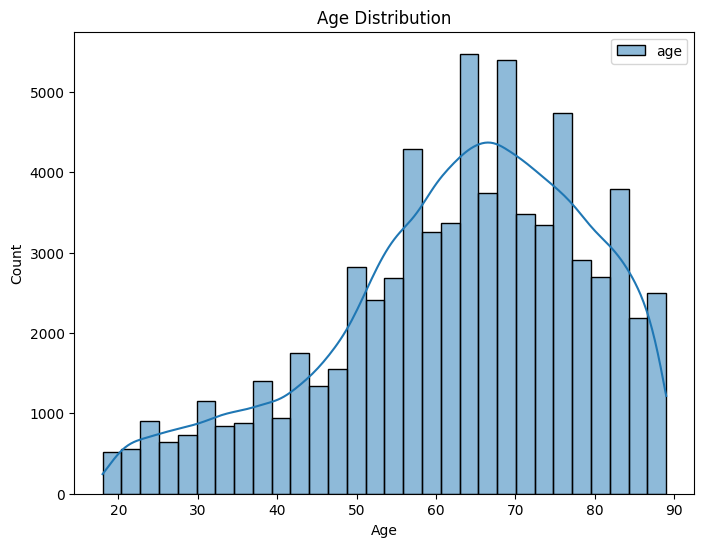

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df[target_col], bins=30, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

In [ ]:
for col in cat_cols:
    print(df[col].value_counts())

gender
M    40981
F    31357
Name: count, dtype: int64
insurance
Medicare     37238
Private      20567
Medicaid     11554
Other         1884
No charge        7
Name: count, dtype: int64
language
English                   65493
Spanish                    2311
Chinese                     869
Russian                     732
Portuguese                  505
Kabuverdianu                473
Haitian                     461
Other                       217
Vietnamese                  197
Italian                     152
Modern Greek (1453-)        141
Arabic                      113
Korean                       58
Khmer                        55
Polish                       54
Persian                      48
American Sign Language       47
Hindi                        36
Thai                         34
Bengali                      29
French                       22
Somali                       17
Amharic                      17
Armenian                     13
Japanese                      7
Name:

In [4]:
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder())
]).fit(df[cat_cols].values[train])

x_cat = cat_pipeline.transform(df[cat_cols].values).astype(np.int64)

cat_cardinalities = (x_cat.max(axis=0) + 1).tolist()
cat_cardinalities

[2, 5, 25, 4, 33]

In [5]:
cont_pipeline = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
]).fit(df[cont_cols].values[train])

x_cont = cont_pipeline.transform(df[cont_cols].values).astype(np.float32)
_, n_cont_features = x_cont.shape
n_cont_features

27

In [6]:
target_pipeline = Pipeline([
    ("scaler", StandardScaler())
]).fit(df[target_col].values[train])

y = target_pipeline.transform(df[target_col].values).astype(np.float32)
y.shape

(72338, 1)

In [65]:
results = {}
split_labels = ['train', 'val']

In [7]:
class TabularDataset(Dataset):
    def __init__(self, x_cont: np.ndarray, x_cat: np.ndarray, y: np.ndarray):
        self.x_cont = torch.tensor(x_cont)
        self.x_cat  = torch.tensor(x_cat)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x_cont[idx], self.x_cat[idx], self.y[idx]

ds = (x_cont, x_cat, y)
train_dataset = TabularDataset(*[a[train] for a in ds])
val_dataset = TabularDataset(*[a[val] for a in ds])

In [8]:
class MLP(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x: torch.Tensor):
        return self.model(x)

In [88]:
def train_mlp(
    batch_size: int = 128,
    lr: float = 2e-3,
    n_epochs: int = 100,
    weight_decay: float = 3e-4,
    patience: int = 10,
    seed: int = 42
    ):

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Lookup and instantiate the model
    model = MLP(num_features=n_cont_features).to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=patience)

    best_score = np.inf
    best_epoch = -1

    # Training loop
    epoch_train_losses = np.empty(n_epochs)
    epoch_val_losses = np.empty(n_epochs)
    for epoch in trange(n_epochs):
        model.train()
        train_losses = []
        for xb, _, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        epoch_train_losses[epoch] = avg_train_loss

        # Validation phase
        model.eval()
        val_losses = []
        with torch.inference_mode():
            for xb, _, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                val_losses.append(loss.item())

        avg_val_loss = np.mean(val_losses)
        scheduler.step(avg_val_loss)
        epoch_val_losses[epoch] = avg_val_loss

        if avg_val_loss < best_score:
            best_score = avg_val_loss
            best_epoch = epoch

        print(
            f" {' ' * max(0, 4 - len(str(epoch+1)))}" +
            f"Epoch [{epoch+1:03d}/{n_epochs}] " +
            f"Train Loss: {avg_train_loss:.4f} " +
            f"Val Loss: {avg_val_loss:.4f} " +
            ("🌸" if epoch == best_epoch else "")
        )

    return dict(zip(split_labels, (epoch_train_losses.tolist(), epoch_val_losses.tolist())))

In [80]:
def clip_best(scores: list[float]) -> list[float]:
    return scores[:np.argmin(scores) + 1]

def unscale_scores(scores: list[float]):
    return [float(np.sqrt(score) * target_pipeline['scaler'].scale_[0]) for score in scores]

def graph_results(splits: list[str] = split_labels, clip: bool = True, unscale: bool = False):
    plt.figure(figsize=(10, 6))
    for model in results.keys():
        for split in splits:
            res = results[model][split]
            if clip:
                res = clip_best(res)
            if unscale:
                res = unscale_scores(res)
            plt.plot(res, label=f'{model} ({split})')
    plt.xlabel('Epoch')
    y_label = 'RMSE (years)' if unscale else 'MSE'
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.show()

In [71]:
results['MLP'] = train_mlp()

  1%|          | 1/100 [00:01<02:39,  1.61s/it]

    Epoch [001/100] Train Loss: 0.6875 Val Loss: 0.5817 🌸


  2%|▏         | 2/100 [00:03<02:56,  1.80s/it]

    Epoch [002/100] Train Loss: 0.5952 Val Loss: 0.5495 🌸


  3%|▎         | 3/100 [00:05<02:40,  1.66s/it]

    Epoch [003/100] Train Loss: 0.5722 Val Loss: 0.5430 🌸


  4%|▍         | 4/100 [00:06<02:40,  1.67s/it]

    Epoch [004/100] Train Loss: 0.5621 Val Loss: 0.5319 🌸


  5%|▌         | 5/100 [00:08<02:37,  1.66s/it]

    Epoch [005/100] Train Loss: 0.5528 Val Loss: 0.5253 🌸


  6%|▌         | 6/100 [00:09<02:30,  1.61s/it]

    Epoch [006/100] Train Loss: 0.5505 Val Loss: 0.5238 🌸


  7%|▋         | 7/100 [00:11<02:25,  1.56s/it]

    Epoch [007/100] Train Loss: 0.5480 Val Loss: 0.5182 🌸


  8%|▊         | 8/100 [00:12<02:21,  1.54s/it]

    Epoch [008/100] Train Loss: 0.5436 Val Loss: 0.5184 


  9%|▉         | 9/100 [00:14<02:28,  1.64s/it]

    Epoch [009/100] Train Loss: 0.5365 Val Loss: 0.5238 


 10%|█         | 10/100 [00:16<02:28,  1.65s/it]

   Epoch [010/100] Train Loss: 0.5363 Val Loss: 0.5152 🌸


 11%|█         | 11/100 [00:17<02:22,  1.60s/it]

   Epoch [011/100] Train Loss: 0.5323 Val Loss: 0.5089 🌸


 12%|█▏        | 12/100 [00:19<02:17,  1.57s/it]

   Epoch [012/100] Train Loss: 0.5300 Val Loss: 0.5104 


 13%|█▎        | 13/100 [00:20<02:14,  1.54s/it]

   Epoch [013/100] Train Loss: 0.5274 Val Loss: 0.5118 


 14%|█▍        | 14/100 [00:22<02:11,  1.53s/it]

   Epoch [014/100] Train Loss: 0.5276 Val Loss: 0.5084 🌸


 15%|█▌        | 15/100 [00:23<02:10,  1.53s/it]

   Epoch [015/100] Train Loss: 0.5263 Val Loss: 0.5076 🌸


 16%|█▌        | 16/100 [00:25<02:07,  1.52s/it]

   Epoch [016/100] Train Loss: 0.5256 Val Loss: 0.5060 🌸


 17%|█▋        | 17/100 [00:27<02:19,  1.68s/it]

   Epoch [017/100] Train Loss: 0.5233 Val Loss: 0.5049 🌸


 18%|█▊        | 18/100 [00:28<02:12,  1.61s/it]

   Epoch [018/100] Train Loss: 0.5223 Val Loss: 0.5062 


 19%|█▉        | 19/100 [00:30<02:07,  1.58s/it]

   Epoch [019/100] Train Loss: 0.5198 Val Loss: 0.5045 🌸


 20%|██        | 20/100 [00:31<02:03,  1.54s/it]

   Epoch [020/100] Train Loss: 0.5183 Val Loss: 0.5033 🌸


 21%|██        | 21/100 [00:33<02:00,  1.53s/it]

   Epoch [021/100] Train Loss: 0.5168 Val Loss: 0.5046 


 22%|██▏       | 22/100 [00:34<01:58,  1.51s/it]

   Epoch [022/100] Train Loss: 0.5194 Val Loss: 0.5024 🌸


 23%|██▎       | 23/100 [00:36<01:55,  1.50s/it]

   Epoch [023/100] Train Loss: 0.5188 Val Loss: 0.5093 


 24%|██▍       | 24/100 [00:37<01:57,  1.55s/it]

   Epoch [024/100] Train Loss: 0.5194 Val Loss: 0.5041 


 25%|██▌       | 25/100 [00:39<02:04,  1.65s/it]

   Epoch [025/100] Train Loss: 0.5149 Val Loss: 0.5026 


 26%|██▌       | 26/100 [00:41<01:58,  1.60s/it]

   Epoch [026/100] Train Loss: 0.5128 Val Loss: 0.5010 🌸


 27%|██▋       | 27/100 [00:42<01:54,  1.57s/it]

   Epoch [027/100] Train Loss: 0.5122 Val Loss: 0.5002 🌸


 28%|██▊       | 28/100 [00:44<01:51,  1.54s/it]

   Epoch [028/100] Train Loss: 0.5112 Val Loss: 0.5010 


 29%|██▉       | 29/100 [00:45<01:48,  1.53s/it]

   Epoch [029/100] Train Loss: 0.5097 Val Loss: 0.4969 🌸


 30%|███       | 30/100 [00:47<01:45,  1.51s/it]

   Epoch [030/100] Train Loss: 0.5094 Val Loss: 0.4983 


 31%|███       | 31/100 [00:48<01:42,  1.49s/it]

   Epoch [031/100] Train Loss: 0.5118 Val Loss: 0.5022 


 32%|███▏      | 32/100 [00:50<01:46,  1.57s/it]

   Epoch [032/100] Train Loss: 0.5099 Val Loss: 0.4971 


 33%|███▎      | 33/100 [00:52<01:49,  1.63s/it]

   Epoch [033/100] Train Loss: 0.5089 Val Loss: 0.4984 


 34%|███▍      | 34/100 [00:53<01:46,  1.61s/it]

   Epoch [034/100] Train Loss: 0.5088 Val Loss: 0.4979 


 35%|███▌      | 35/100 [00:55<01:42,  1.58s/it]

   Epoch [035/100] Train Loss: 0.5055 Val Loss: 0.5019 


 36%|███▌      | 36/100 [00:56<01:39,  1.55s/it]

   Epoch [036/100] Train Loss: 0.5092 Val Loss: 0.4930 🌸


 37%|███▋      | 37/100 [00:58<01:36,  1.53s/it]

   Epoch [037/100] Train Loss: 0.5087 Val Loss: 0.5031 


 38%|███▊      | 38/100 [00:59<01:33,  1.51s/it]

   Epoch [038/100] Train Loss: 0.5076 Val Loss: 0.4949 


 39%|███▉      | 39/100 [01:01<01:31,  1.50s/it]

   Epoch [039/100] Train Loss: 0.5053 Val Loss: 0.4967 


 40%|████      | 40/100 [01:03<01:36,  1.61s/it]

   Epoch [040/100] Train Loss: 0.5041 Val Loss: 0.4966 


 41%|████      | 41/100 [01:04<01:36,  1.64s/it]

   Epoch [041/100] Train Loss: 0.5026 Val Loss: 0.4973 


 42%|████▏     | 42/100 [01:06<01:31,  1.59s/it]

   Epoch [042/100] Train Loss: 0.5037 Val Loss: 0.4965 


 43%|████▎     | 43/100 [01:07<01:28,  1.56s/it]

   Epoch [043/100] Train Loss: 0.5036 Val Loss: 0.4991 


 44%|████▍     | 44/100 [01:09<01:25,  1.53s/it]

   Epoch [044/100] Train Loss: 0.5054 Val Loss: 0.4962 


 45%|████▌     | 45/100 [01:10<01:23,  1.52s/it]

   Epoch [045/100] Train Loss: 0.5042 Val Loss: 0.5003 


 46%|████▌     | 46/100 [01:12<01:21,  1.51s/it]

   Epoch [046/100] Train Loss: 0.5027 Val Loss: 0.4934 


 47%|████▋     | 47/100 [01:13<01:19,  1.50s/it]

   Epoch [047/100] Train Loss: 0.4988 Val Loss: 0.4942 


 48%|████▊     | 48/100 [01:15<01:26,  1.67s/it]

   Epoch [048/100] Train Loss: 0.4950 Val Loss: 0.4894 🌸


 49%|████▉     | 49/100 [01:17<01:22,  1.61s/it]

   Epoch [049/100] Train Loss: 0.4931 Val Loss: 0.4906 


 50%|█████     | 50/100 [01:18<01:18,  1.56s/it]

   Epoch [050/100] Train Loss: 0.4921 Val Loss: 0.4909 


 51%|█████     | 51/100 [01:20<01:15,  1.54s/it]

   Epoch [051/100] Train Loss: 0.4905 Val Loss: 0.4890 🌸


 52%|█████▏    | 52/100 [01:21<01:12,  1.52s/it]

   Epoch [052/100] Train Loss: 0.4902 Val Loss: 0.4898 


 53%|█████▎    | 53/100 [01:23<01:10,  1.50s/it]

   Epoch [053/100] Train Loss: 0.4910 Val Loss: 0.4917 


 54%|█████▍    | 54/100 [01:24<01:09,  1.51s/it]

   Epoch [054/100] Train Loss: 0.4890 Val Loss: 0.4892 


 55%|█████▌    | 55/100 [01:26<01:08,  1.53s/it]

   Epoch [055/100] Train Loss: 0.4913 Val Loss: 0.4912 


 56%|█████▌    | 56/100 [01:28<01:12,  1.64s/it]

   Epoch [056/100] Train Loss: 0.4884 Val Loss: 0.4890 🌸


 57%|█████▋    | 57/100 [01:29<01:08,  1.59s/it]

   Epoch [057/100] Train Loss: 0.4885 Val Loss: 0.4904 


 58%|█████▊    | 58/100 [01:30<01:05,  1.56s/it]

   Epoch [058/100] Train Loss: 0.4882 Val Loss: 0.4893 


 59%|█████▉    | 59/100 [01:32<01:02,  1.53s/it]

   Epoch [059/100] Train Loss: 0.4864 Val Loss: 0.4908 


 60%|██████    | 60/100 [01:33<01:00,  1.52s/it]

   Epoch [060/100] Train Loss: 0.4868 Val Loss: 0.4878 🌸


 61%|██████    | 61/100 [01:35<00:58,  1.51s/it]

   Epoch [061/100] Train Loss: 0.4884 Val Loss: 0.4890 


 62%|██████▏   | 62/100 [01:36<00:56,  1.50s/it]

   Epoch [062/100] Train Loss: 0.4876 Val Loss: 0.4915 


 63%|██████▎   | 63/100 [01:38<00:57,  1.56s/it]

   Epoch [063/100] Train Loss: 0.4859 Val Loss: 0.4903 


 64%|██████▍   | 64/100 [01:40<00:59,  1.64s/it]

   Epoch [064/100] Train Loss: 0.4869 Val Loss: 0.4903 


 65%|██████▌   | 65/100 [01:41<00:55,  1.59s/it]

   Epoch [065/100] Train Loss: 0.4849 Val Loss: 0.4885 


 66%|██████▌   | 66/100 [01:43<00:52,  1.55s/it]

   Epoch [066/100] Train Loss: 0.4876 Val Loss: 0.4912 


 67%|██████▋   | 67/100 [01:44<00:50,  1.53s/it]

   Epoch [067/100] Train Loss: 0.4845 Val Loss: 0.4889 


 68%|██████▊   | 68/100 [01:46<00:48,  1.51s/it]

   Epoch [068/100] Train Loss: 0.4839 Val Loss: 0.4885 


 69%|██████▉   | 69/100 [01:47<00:46,  1.50s/it]

   Epoch [069/100] Train Loss: 0.4844 Val Loss: 0.4896 


 70%|███████   | 70/100 [01:49<00:44,  1.49s/it]

   Epoch [070/100] Train Loss: 0.4815 Val Loss: 0.4886 


 71%|███████   | 71/100 [01:51<00:45,  1.58s/it]

   Epoch [071/100] Train Loss: 0.4841 Val Loss: 0.4911 


 72%|███████▏  | 72/100 [01:52<00:45,  1.63s/it]

   Epoch [072/100] Train Loss: 0.4813 Val Loss: 0.4877 🌸


 73%|███████▎  | 73/100 [01:54<00:43,  1.60s/it]

   Epoch [073/100] Train Loss: 0.4786 Val Loss: 0.4861 🌸


 74%|███████▍  | 74/100 [01:55<00:40,  1.56s/it]

   Epoch [074/100] Train Loss: 0.4790 Val Loss: 0.4875 


 75%|███████▌  | 75/100 [01:57<00:38,  1.53s/it]

   Epoch [075/100] Train Loss: 0.4795 Val Loss: 0.4878 


 76%|███████▌  | 76/100 [01:58<00:36,  1.51s/it]

   Epoch [076/100] Train Loss: 0.4768 Val Loss: 0.4867 


 77%|███████▋  | 77/100 [02:00<00:34,  1.50s/it]

   Epoch [077/100] Train Loss: 0.4785 Val Loss: 0.4880 


 78%|███████▊  | 78/100 [02:01<00:32,  1.50s/it]

   Epoch [078/100] Train Loss: 0.4792 Val Loss: 0.4868 


 79%|███████▉  | 79/100 [02:03<00:34,  1.63s/it]

   Epoch [079/100] Train Loss: 0.4793 Val Loss: 0.4869 


 80%|████████  | 80/100 [02:05<00:32,  1.62s/it]

   Epoch [080/100] Train Loss: 0.4786 Val Loss: 0.4856 🌸


 81%|████████  | 81/100 [02:06<00:30,  1.58s/it]

   Epoch [081/100] Train Loss: 0.4756 Val Loss: 0.4858 


 82%|████████▏ | 82/100 [02:08<00:27,  1.55s/it]

   Epoch [082/100] Train Loss: 0.4765 Val Loss: 0.4876 


 83%|████████▎ | 83/100 [02:09<00:26,  1.54s/it]

   Epoch [083/100] Train Loss: 0.4783 Val Loss: 0.4884 


 84%|████████▍ | 84/100 [02:11<00:24,  1.53s/it]

   Epoch [084/100] Train Loss: 0.4772 Val Loss: 0.4894 


 85%|████████▌ | 85/100 [02:12<00:22,  1.53s/it]

   Epoch [085/100] Train Loss: 0.4756 Val Loss: 0.4889 


 86%|████████▌ | 86/100 [02:14<00:21,  1.56s/it]

   Epoch [086/100] Train Loss: 0.4776 Val Loss: 0.4890 


 87%|████████▋ | 87/100 [02:16<00:21,  1.68s/it]

   Epoch [087/100] Train Loss: 0.4779 Val Loss: 0.4884 


 88%|████████▊ | 88/100 [02:17<00:19,  1.63s/it]

   Epoch [088/100] Train Loss: 0.4768 Val Loss: 0.4874 


 89%|████████▉ | 89/100 [02:19<00:17,  1.62s/it]

   Epoch [089/100] Train Loss: 0.4772 Val Loss: 0.4889 


 90%|█████████ | 90/100 [02:20<00:15,  1.58s/it]

   Epoch [090/100] Train Loss: 0.4762 Val Loss: 0.4880 


 91%|█████████ | 91/100 [02:22<00:14,  1.56s/it]

   Epoch [091/100] Train Loss: 0.4751 Val Loss: 0.4873 


 92%|█████████▏| 92/100 [02:23<00:12,  1.54s/it]

   Epoch [092/100] Train Loss: 0.4734 Val Loss: 0.4871 


 93%|█████████▎| 93/100 [02:25<00:10,  1.53s/it]

   Epoch [093/100] Train Loss: 0.4713 Val Loss: 0.4871 


 94%|█████████▍| 94/100 [02:27<00:09,  1.60s/it]

   Epoch [094/100] Train Loss: 0.4716 Val Loss: 0.4871 


 95%|█████████▌| 95/100 [02:28<00:08,  1.64s/it]

   Epoch [095/100] Train Loss: 0.4709 Val Loss: 0.4868 


 96%|█████████▌| 96/100 [02:30<00:06,  1.59s/it]

   Epoch [096/100] Train Loss: 0.4728 Val Loss: 0.4869 


 97%|█████████▋| 97/100 [02:31<00:04,  1.56s/it]

   Epoch [097/100] Train Loss: 0.4737 Val Loss: 0.4864 


 98%|█████████▊| 98/100 [02:33<00:03,  1.53s/it]

   Epoch [098/100] Train Loss: 0.4716 Val Loss: 0.4864 


 99%|█████████▉| 99/100 [02:34<00:01,  1.52s/it]

   Epoch [099/100] Train Loss: 0.4717 Val Loss: 0.4866 


100%|██████████| 100/100 [02:36<00:00,  1.56s/it]

  Epoch [100/100] Train Loss: 0.4716 Val Loss: 0.4868 


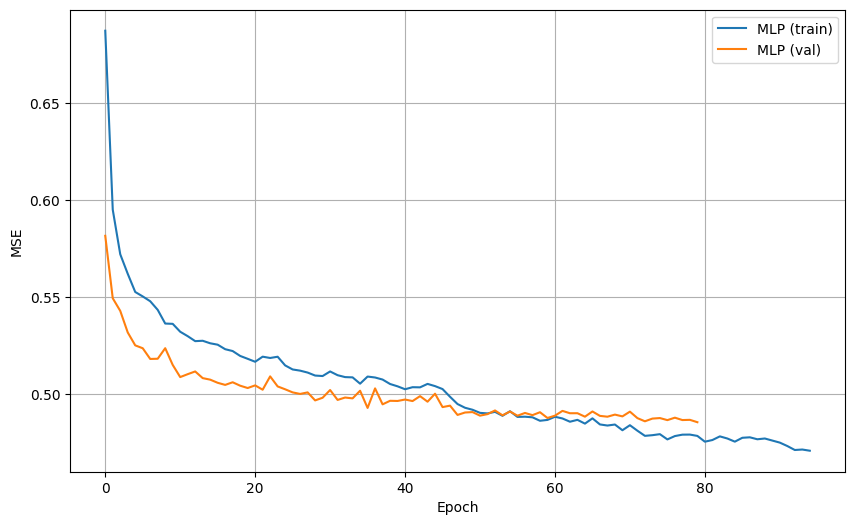

In [72]:
graph_results()

In [89]:
def train_tabm(
    use_categoricals: bool = True,
    n_epochs = 100,
    patience = 10,
    batch_size = 256,
    eval_batch_size = 8192,
    k: int = 32,
    lr: float = 2e-3,
    weight_decay: float = 3e-4,
    n_blocks: int = 3,
    d_block: int = 512,
    dropout: float = 0.1,
    seed: int = 42,
):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    amp = torch.cuda.is_available() and torch.cuda.is_bf16_supported()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=eval_batch_size)

    model = Model(
        n_num_features=n_cont_features,
        cat_cardinalities=cat_cardinalities if use_categoricals else [],
        n_classes=None,
        backbone={
            'type': 'MLP',
            'n_blocks': n_blocks,
            'd_block': d_block,
            'dropout': dropout,
        },
        bins=None,
        arch_type='tabm',
        k=k,
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(make_parameter_groups(model), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=patience)

    best_score = np.inf
    best_epoch = -1
    epoch_train_losses = np.empty(n_epochs)
    epoch_val_losses = np.empty(n_epochs)
    for epoch in trange(n_epochs):
        model.train()
        train_losses = []
        for xnb, xcb, yb in train_loader:
            optimizer.zero_grad()
            xnb, xcb, yb = xnb.to(device), xcb.to(device), yb.to(device)
            with torch.autocast(device.type, enabled=amp, dtype=torch.bfloat16):
                out = model(xnb, xcb if use_categoricals else None).squeeze(-1)
            loss = criterion(out.float().flatten(0, 1), yb.repeat_interleave(k))
            train_losses += [loss.item()]
            loss.backward()
            optimizer.step()
        avg_train_loss = np.mean(train_losses)
        epoch_train_losses[epoch] = avg_train_loss

        model.eval()
        val_losses = []
        with torch.inference_mode():
            for xnb, xcb, yb in val_loader:
                xnb, xcb, yb = xnb.to(device), xcb.to(device), yb.to(device)
                with torch.autocast(device.type, enabled=amp, dtype=torch.bfloat16):
                    out = model(xnb, xcb if use_categoricals else None).squeeze(-1)
                loss = criterion(out.float().mean(dim=1, keepdim=True), yb)
                val_losses += [loss.item()]
            avg_val_loss = np.mean(val_losses)
            epoch_val_losses[epoch] = avg_val_loss
            scheduler.step(avg_val_loss)

        if avg_val_loss < best_score:
            best_score = avg_val_loss
            best_epoch = epoch

        print(
            f" {' ' * max(0, 4 - len(str(epoch+1)))}" +
            f"Epoch [{epoch+1:03d}/{n_epochs}] " +
            f"Train Loss: {avg_train_loss:.4f} " +
            f"Val Loss: {avg_val_loss:.4f} " +
            ("🌸" if epoch == best_epoch else "")
        )

    return dict(zip(split_labels, (epoch_train_losses.tolist(), epoch_val_losses.tolist())))

In [74]:
results['TabM'] = train_tabm(use_categoricals=False)

  1%|          | 1/100 [00:04<07:41,  4.67s/it]

    Epoch [001/100] Train Loss: 0.7359 Val Loss: 0.6461 🌸


  2%|▏         | 2/100 [00:08<07:16,  4.46s/it]

    Epoch [002/100] Train Loss: 0.5922 Val Loss: 0.5294 🌸


  3%|▎         | 3/100 [00:13<07:19,  4.53s/it]

    Epoch [003/100] Train Loss: 0.5674 Val Loss: 0.5261 🌸


  4%|▍         | 4/100 [00:18<07:30,  4.69s/it]

    Epoch [004/100] Train Loss: 0.5514 Val Loss: 0.5168 🌸


  5%|▌         | 5/100 [00:22<07:13,  4.56s/it]

    Epoch [005/100] Train Loss: 0.5435 Val Loss: 0.5110 🌸


  6%|▌         | 6/100 [00:27<07:13,  4.61s/it]

    Epoch [006/100] Train Loss: 0.5382 Val Loss: 0.5111 


  7%|▋         | 7/100 [00:31<06:58,  4.50s/it]

    Epoch [007/100] Train Loss: 0.5317 Val Loss: 0.5073 🌸


  8%|▊         | 8/100 [00:36<06:53,  4.50s/it]

    Epoch [008/100] Train Loss: 0.5280 Val Loss: 0.5063 🌸


  9%|▉         | 9/100 [00:40<06:50,  4.51s/it]

    Epoch [009/100] Train Loss: 0.5243 Val Loss: 0.5042 🌸


 10%|█         | 10/100 [00:45<06:37,  4.41s/it]

   Epoch [010/100] Train Loss: 0.5188 Val Loss: 0.5006 🌸


 11%|█         | 11/100 [00:49<06:33,  4.42s/it]

   Epoch [011/100] Train Loss: 0.5171 Val Loss: 0.4994 🌸


 12%|█▏        | 12/100 [00:53<06:22,  4.35s/it]

   Epoch [012/100] Train Loss: 0.5146 Val Loss: 0.5810 


 13%|█▎        | 13/100 [00:58<06:19,  4.36s/it]

   Epoch [013/100] Train Loss: 0.5117 Val Loss: 0.5017 


 14%|█▍        | 14/100 [01:02<06:18,  4.40s/it]

   Epoch [014/100] Train Loss: 0.5139 Val Loss: 0.4964 🌸


 15%|█▌        | 15/100 [01:06<06:08,  4.33s/it]

   Epoch [015/100] Train Loss: 0.5298 Val Loss: 0.4969 


 16%|█▌        | 16/100 [01:11<06:05,  4.35s/it]

   Epoch [016/100] Train Loss: 0.5372 Val Loss: 0.4945 🌸


 17%|█▋        | 17/100 [01:15<05:58,  4.32s/it]

   Epoch [017/100] Train Loss: 0.5091 Val Loss: 0.4935 🌸


 18%|█▊        | 18/100 [01:19<05:56,  4.34s/it]

   Epoch [018/100] Train Loss: 0.5044 Val Loss: 0.4946 


 19%|█▉        | 19/100 [01:24<05:53,  4.37s/it]

   Epoch [019/100] Train Loss: 0.5028 Val Loss: 0.4917 🌸


 20%|██        | 20/100 [01:28<05:46,  4.33s/it]

   Epoch [020/100] Train Loss: 0.4992 Val Loss: 0.4936 


 21%|██        | 21/100 [01:32<05:44,  4.36s/it]

   Epoch [021/100] Train Loss: 0.4976 Val Loss: 0.4915 🌸


 22%|██▏       | 22/100 [01:37<05:36,  4.31s/it]

   Epoch [022/100] Train Loss: 0.4948 Val Loss: 0.4858 🌸


 23%|██▎       | 23/100 [01:41<05:35,  4.36s/it]

   Epoch [023/100] Train Loss: 0.4946 Val Loss: 0.4857 🌸


 24%|██▍       | 24/100 [01:45<05:33,  4.39s/it]

   Epoch [024/100] Train Loss: 0.4933 Val Loss: 0.4877 


 25%|██▌       | 25/100 [01:50<05:25,  4.34s/it]

   Epoch [025/100] Train Loss: 0.4882 Val Loss: 0.4868 


 26%|██▌       | 26/100 [01:54<05:24,  4.38s/it]

   Epoch [026/100] Train Loss: 0.4866 Val Loss: 0.4840 🌸


 27%|██▋       | 27/100 [01:58<05:16,  4.33s/it]

   Epoch [027/100] Train Loss: 0.4854 Val Loss: 0.4871 


 28%|██▊       | 28/100 [02:03<05:16,  4.39s/it]

   Epoch [028/100] Train Loss: 0.4831 Val Loss: 0.4859 


 29%|██▉       | 29/100 [02:07<05:13,  4.41s/it]

   Epoch [029/100] Train Loss: 0.4815 Val Loss: 0.4893 


 30%|███       | 30/100 [02:12<05:04,  4.35s/it]

   Epoch [030/100] Train Loss: 0.4795 Val Loss: 0.4842 


 31%|███       | 31/100 [02:16<05:04,  4.42s/it]

   Epoch [031/100] Train Loss: 0.4788 Val Loss: 0.4809 🌸


 32%|███▏      | 32/100 [02:20<04:55,  4.35s/it]

   Epoch [032/100] Train Loss: 0.4797 Val Loss: 0.4796 🌸


 33%|███▎      | 33/100 [02:25<04:52,  4.36s/it]

   Epoch [033/100] Train Loss: 0.4758 Val Loss: 0.4797 


 34%|███▍      | 34/100 [02:29<04:49,  4.38s/it]

   Epoch [034/100] Train Loss: 0.4743 Val Loss: 0.4823 


 35%|███▌      | 35/100 [02:33<04:41,  4.33s/it]

   Epoch [035/100] Train Loss: 0.4756 Val Loss: 0.4804 


 36%|███▌      | 36/100 [02:38<04:38,  4.35s/it]

   Epoch [036/100] Train Loss: 0.4897 Val Loss: 0.4834 


 37%|███▋      | 37/100 [02:42<04:31,  4.31s/it]

   Epoch [037/100] Train Loss: 0.4730 Val Loss: 0.4786 🌸


 38%|███▊      | 38/100 [02:46<04:28,  4.33s/it]

   Epoch [038/100] Train Loss: 0.4700 Val Loss: 0.4764 🌸


 39%|███▉      | 39/100 [02:51<04:27,  4.39s/it]

   Epoch [039/100] Train Loss: 0.4686 Val Loss: 0.4779 


 40%|████      | 40/100 [02:55<04:20,  4.34s/it]

   Epoch [040/100] Train Loss: 0.4657 Val Loss: 0.4777 


 41%|████      | 41/100 [03:00<04:17,  4.36s/it]

   Epoch [041/100] Train Loss: 0.4651 Val Loss: 0.4755 🌸


 42%|████▏     | 42/100 [03:04<04:16,  4.43s/it]

   Epoch [042/100] Train Loss: 0.4633 Val Loss: 0.4776 


 43%|████▎     | 43/100 [03:08<04:08,  4.37s/it]

   Epoch [043/100] Train Loss: 0.4634 Val Loss: 0.4769 


 44%|████▍     | 44/100 [03:13<04:06,  4.39s/it]

   Epoch [044/100] Train Loss: 0.4621 Val Loss: 0.4739 🌸


 45%|████▌     | 45/100 [03:17<03:58,  4.34s/it]

   Epoch [045/100] Train Loss: 0.4611 Val Loss: 0.4754 


 46%|████▌     | 46/100 [03:21<03:55,  4.36s/it]

   Epoch [046/100] Train Loss: 0.4614 Val Loss: 0.4745 


 47%|████▋     | 47/100 [03:26<03:52,  4.38s/it]

   Epoch [047/100] Train Loss: 0.4621 Val Loss: 0.4762 


 48%|████▊     | 48/100 [03:30<03:45,  4.34s/it]

   Epoch [048/100] Train Loss: 0.4636 Val Loss: 0.4742 


 49%|████▉     | 49/100 [03:35<03:42,  4.36s/it]

   Epoch [049/100] Train Loss: 0.4873 Val Loss: 0.4742 


 50%|█████     | 50/100 [03:39<03:36,  4.32s/it]

   Epoch [050/100] Train Loss: 0.5503 Val Loss: 0.4714 🌸


 51%|█████     | 51/100 [03:43<03:33,  4.35s/it]

   Epoch [051/100] Train Loss: 0.4580 Val Loss: 0.4773 


 52%|█████▏    | 52/100 [03:48<03:29,  4.37s/it]

   Epoch [052/100] Train Loss: 0.4559 Val Loss: 0.4715 


 53%|█████▎    | 53/100 [03:52<03:23,  4.34s/it]

   Epoch [053/100] Train Loss: 0.4573 Val Loss: 0.4705 🌸


 54%|█████▍    | 54/100 [03:56<03:20,  4.37s/it]

   Epoch [054/100] Train Loss: 0.4539 Val Loss: 0.4694 🌸


 55%|█████▌    | 55/100 [04:00<03:14,  4.31s/it]

   Epoch [055/100] Train Loss: 0.4529 Val Loss: 0.4704 


 56%|█████▌    | 56/100 [04:05<03:11,  4.35s/it]

   Epoch [056/100] Train Loss: 0.4549 Val Loss: 0.4694 


 57%|█████▋    | 57/100 [04:09<03:08,  4.37s/it]

   Epoch [057/100] Train Loss: 0.4507 Val Loss: 0.4785 


 58%|█████▊    | 58/100 [04:14<03:01,  4.32s/it]

   Epoch [058/100] Train Loss: 0.4556 Val Loss: 0.4703 


 59%|█████▉    | 59/100 [04:18<02:58,  4.36s/it]

   Epoch [059/100] Train Loss: 0.4506 Val Loss: 0.4705 


 60%|██████    | 60/100 [04:22<02:55,  4.38s/it]

   Epoch [060/100] Train Loss: 0.4493 Val Loss: 0.4686 🌸


 61%|██████    | 61/100 [04:27<02:48,  4.32s/it]

   Epoch [061/100] Train Loss: 0.4454 Val Loss: 0.4710 


 62%|██████▏   | 62/100 [04:31<02:45,  4.35s/it]

   Epoch [062/100] Train Loss: 0.4474 Val Loss: 0.4687 


 63%|██████▎   | 63/100 [04:35<02:39,  4.30s/it]

   Epoch [063/100] Train Loss: 0.4478 Val Loss: 0.4696 


 64%|██████▍   | 64/100 [04:40<02:36,  4.35s/it]

   Epoch [064/100] Train Loss: 0.4457 Val Loss: 0.4697 


 65%|██████▌   | 65/100 [04:44<02:33,  4.37s/it]

   Epoch [065/100] Train Loss: 0.4720 Val Loss: 0.4724 


 66%|██████▌   | 66/100 [04:48<02:26,  4.32s/it]

   Epoch [066/100] Train Loss: 0.4480 Val Loss: 0.4696 


 67%|██████▋   | 67/100 [04:53<02:24,  4.39s/it]

   Epoch [067/100] Train Loss: 0.5689 Val Loss: 0.4710 


 68%|██████▊   | 68/100 [04:57<02:20,  4.40s/it]

   Epoch [068/100] Train Loss: 0.4482 Val Loss: 0.4681 🌸


 69%|██████▉   | 69/100 [05:01<02:14,  4.34s/it]

   Epoch [069/100] Train Loss: 0.4897 Val Loss: 0.4709 


 70%|███████   | 70/100 [05:06<02:10,  4.36s/it]

   Epoch [070/100] Train Loss: 0.4412 Val Loss: 0.4730 


 71%|███████   | 71/100 [05:10<02:05,  4.31s/it]

   Epoch [071/100] Train Loss: 0.4414 Val Loss: 0.4681 


 72%|███████▏  | 72/100 [05:14<02:01,  4.34s/it]

   Epoch [072/100] Train Loss: 0.4430 Val Loss: 0.4697 


 73%|███████▎  | 73/100 [05:19<01:58,  4.38s/it]

   Epoch [073/100] Train Loss: 0.4431 Val Loss: 0.4690 


 74%|███████▍  | 74/100 [05:23<01:52,  4.33s/it]

   Epoch [074/100] Train Loss: 0.4469 Val Loss: 0.4705 


 75%|███████▌  | 75/100 [05:28<01:49,  4.39s/it]

   Epoch [075/100] Train Loss: 0.4459 Val Loss: 0.4720 


 76%|███████▌  | 76/100 [05:32<01:44,  4.34s/it]

   Epoch [076/100] Train Loss: 0.4364 Val Loss: 0.4691 


 77%|███████▋  | 77/100 [05:36<01:40,  4.36s/it]

   Epoch [077/100] Train Loss: 0.4387 Val Loss: 0.4680 🌸


 78%|███████▊  | 78/100 [05:41<01:37,  4.42s/it]

   Epoch [078/100] Train Loss: 0.4363 Val Loss: 0.4683 


 79%|███████▉  | 79/100 [05:45<01:31,  4.36s/it]

   Epoch [079/100] Train Loss: 0.4347 Val Loss: 0.4714 


 80%|████████  | 80/100 [05:50<01:27,  4.38s/it]

   Epoch [080/100] Train Loss: 0.4379 Val Loss: 0.4687 


 81%|████████  | 81/100 [05:54<01:23,  4.40s/it]

   Epoch [081/100] Train Loss: 0.4440 Val Loss: 0.4678 🌸


 82%|████████▏ | 82/100 [05:58<01:18,  4.35s/it]

   Epoch [082/100] Train Loss: 0.4383 Val Loss: 0.4669 🌸


 83%|████████▎ | 83/100 [06:03<01:14,  4.38s/it]

   Epoch [083/100] Train Loss: 0.4366 Val Loss: 0.4693 


 84%|████████▍ | 84/100 [06:07<01:09,  4.33s/it]

   Epoch [084/100] Train Loss: 0.4325 Val Loss: 0.4668 🌸


 85%|████████▌ | 85/100 [06:11<01:05,  4.36s/it]

   Epoch [085/100] Train Loss: 0.4372 Val Loss: 0.4679 


 86%|████████▌ | 86/100 [06:16<01:01,  4.41s/it]

   Epoch [086/100] Train Loss: 0.4308 Val Loss: 0.4671 


 87%|████████▋ | 87/100 [06:20<00:56,  4.36s/it]

   Epoch [087/100] Train Loss: 0.4291 Val Loss: 0.4693 


 88%|████████▊ | 88/100 [06:25<00:52,  4.37s/it]

   Epoch [088/100] Train Loss: 0.4284 Val Loss: 0.4657 🌸


 89%|████████▉ | 89/100 [06:29<00:47,  4.34s/it]

   Epoch [089/100] Train Loss: 0.4286 Val Loss: 0.4655 🌸


 90%|█████████ | 90/100 [06:33<00:43,  4.36s/it]

   Epoch [090/100] Train Loss: 0.4270 Val Loss: 0.4651 🌸


 91%|█████████ | 91/100 [06:38<00:39,  4.38s/it]

   Epoch [091/100] Train Loss: 0.4595 Val Loss: 0.4700 


 92%|█████████▏| 92/100 [06:42<00:34,  4.33s/it]

   Epoch [092/100] Train Loss: 0.4433 Val Loss: 0.4654 


 93%|█████████▎| 93/100 [06:46<00:30,  4.36s/it]

   Epoch [093/100] Train Loss: 0.4287 Val Loss: 0.4765 


 94%|█████████▍| 94/100 [06:51<00:26,  4.37s/it]

   Epoch [094/100] Train Loss: 0.4264 Val Loss: 0.4677 


 95%|█████████▌| 95/100 [06:55<00:21,  4.33s/it]

   Epoch [095/100] Train Loss: 0.4282 Val Loss: 0.4667 


 96%|█████████▌| 96/100 [06:59<00:17,  4.35s/it]

   Epoch [096/100] Train Loss: 0.4431 Val Loss: 0.4656 


 97%|█████████▋| 97/100 [07:04<00:12,  4.32s/it]

   Epoch [097/100] Train Loss: 0.4272 Val Loss: 0.4664 


 98%|█████████▊| 98/100 [07:08<00:08,  4.36s/it]

   Epoch [098/100] Train Loss: 0.4274 Val Loss: 0.4683 


 99%|█████████▉| 99/100 [07:12<00:04,  4.31s/it]

   Epoch [099/100] Train Loss: 0.4283 Val Loss: 0.4699 


100%|██████████| 100/100 [07:17<00:00,  4.37s/it]

  Epoch [100/100] Train Loss: 0.4253 Val Loss: 0.4669 


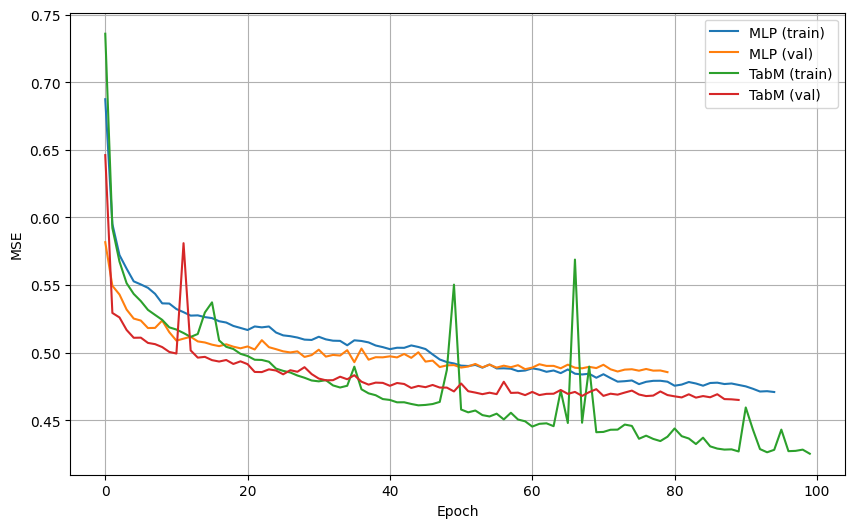

In [75]:
graph_results()

In [76]:
results['TabM (with categoricals)'] = train_tabm(use_categoricals=True)

  1%|          | 1/100 [00:04<07:38,  4.63s/it]

    Epoch [001/100] Train Loss: 0.7632 Val Loss: 0.4505 🌸


  2%|▏         | 2/100 [00:09<07:19,  4.48s/it]

    Epoch [002/100] Train Loss: 0.4508 Val Loss: 0.4127 🌸


  3%|▎         | 3/100 [00:13<07:20,  4.55s/it]

    Epoch [003/100] Train Loss: 0.4573 Val Loss: 0.3989 🌸


  4%|▍         | 4/100 [00:18<07:18,  4.57s/it]

    Epoch [004/100] Train Loss: 0.4120 Val Loss: 0.3995 


  5%|▌         | 5/100 [00:22<07:07,  4.50s/it]

    Epoch [005/100] Train Loss: 0.4943 Val Loss: 0.4050 


  6%|▌         | 6/100 [00:27<07:07,  4.55s/it]

    Epoch [006/100] Train Loss: 0.3950 Val Loss: 0.4072 


  7%|▋         | 7/100 [00:31<06:57,  4.49s/it]

    Epoch [007/100] Train Loss: 0.3864 Val Loss: 0.3720 🌸


  8%|▊         | 8/100 [00:36<06:58,  4.54s/it]

    Epoch [008/100] Train Loss: 0.3778 Val Loss: 0.3750 


  9%|▉         | 9/100 [00:40<06:55,  4.57s/it]

    Epoch [009/100] Train Loss: 0.3718 Val Loss: 0.3621 🌸


 10%|█         | 10/100 [00:45<06:45,  4.51s/it]

   Epoch [010/100] Train Loss: 0.3648 Val Loss: 0.3742 


 11%|█         | 11/100 [00:49<06:45,  4.56s/it]

   Epoch [011/100] Train Loss: 0.3601 Val Loss: 0.3656 


 12%|█▏        | 12/100 [00:54<06:41,  4.57s/it]

   Epoch [012/100] Train Loss: 0.3568 Val Loss: 0.3560 🌸


 13%|█▎        | 13/100 [00:58<06:32,  4.52s/it]

   Epoch [013/100] Train Loss: 0.3542 Val Loss: 0.3554 🌸


 14%|█▍        | 14/100 [01:03<06:30,  4.54s/it]

   Epoch [014/100] Train Loss: 0.3522 Val Loss: 0.3516 🌸


 15%|█▌        | 15/100 [01:08<06:27,  4.55s/it]

   Epoch [015/100] Train Loss: 0.3503 Val Loss: 0.3735 


 16%|█▌        | 16/100 [01:12<06:19,  4.52s/it]

   Epoch [016/100] Train Loss: 0.3505 Val Loss: 0.3579 


 17%|█▋        | 17/100 [01:17<06:16,  4.54s/it]

   Epoch [017/100] Train Loss: 0.3464 Val Loss: 0.3535 


 18%|█▊        | 18/100 [01:21<06:07,  4.48s/it]

   Epoch [018/100] Train Loss: 0.3446 Val Loss: 0.3547 


 19%|█▉        | 19/100 [01:26<06:05,  4.52s/it]

   Epoch [019/100] Train Loss: 0.3436 Val Loss: 0.3484 🌸


 20%|██        | 20/100 [01:30<05:57,  4.47s/it]

   Epoch [020/100] Train Loss: 0.3426 Val Loss: 0.3488 


 21%|██        | 21/100 [01:34<05:54,  4.49s/it]

   Epoch [021/100] Train Loss: 0.3382 Val Loss: 0.3468 🌸


 22%|██▏       | 22/100 [01:39<05:53,  4.53s/it]

   Epoch [022/100] Train Loss: 0.3374 Val Loss: 0.3473 


 23%|██▎       | 23/100 [01:43<05:44,  4.47s/it]

   Epoch [023/100] Train Loss: 0.3370 Val Loss: 0.3468 


 24%|██▍       | 24/100 [01:48<05:45,  4.54s/it]

   Epoch [024/100] Train Loss: 0.3344 Val Loss: 0.3462 🌸


 25%|██▌       | 25/100 [01:53<05:41,  4.55s/it]

   Epoch [025/100] Train Loss: 0.3334 Val Loss: 0.3459 🌸


 26%|██▌       | 26/100 [01:57<05:32,  4.49s/it]

   Epoch [026/100] Train Loss: 0.3319 Val Loss: 0.3459 


 27%|██▋       | 27/100 [02:02<05:30,  4.53s/it]

   Epoch [027/100] Train Loss: 0.3308 Val Loss: 0.3436 🌸


 28%|██▊       | 28/100 [02:06<05:22,  4.48s/it]

   Epoch [028/100] Train Loss: 0.3298 Val Loss: 0.3416 🌸


 29%|██▉       | 29/100 [02:11<05:20,  4.52s/it]

   Epoch [029/100] Train Loss: 0.3340 Val Loss: 0.3461 


 30%|███       | 30/100 [02:15<05:18,  4.55s/it]

   Epoch [030/100] Train Loss: 0.3268 Val Loss: 0.3424 


 31%|███       | 31/100 [02:20<05:09,  4.49s/it]

   Epoch [031/100] Train Loss: 0.3248 Val Loss: 0.3446 


 32%|███▏      | 32/100 [02:24<05:10,  4.56s/it]

   Epoch [032/100] Train Loss: 0.3253 Val Loss: 0.3402 🌸


 33%|███▎      | 33/100 [02:29<05:02,  4.51s/it]

   Epoch [033/100] Train Loss: 0.3228 Val Loss: 0.3398 🌸


 34%|███▍      | 34/100 [02:33<05:00,  4.55s/it]

   Epoch [034/100] Train Loss: 0.3220 Val Loss: 0.4207 


 35%|███▌      | 35/100 [02:38<04:52,  4.50s/it]

   Epoch [035/100] Train Loss: 0.3222 Val Loss: 0.3428 


 36%|███▌      | 36/100 [02:42<04:49,  4.53s/it]

   Epoch [036/100] Train Loss: 0.3217 Val Loss: 0.3414 


 37%|███▋      | 37/100 [02:47<04:47,  4.56s/it]

   Epoch [037/100] Train Loss: 0.3183 Val Loss: 0.3410 


 38%|███▊      | 38/100 [02:51<04:39,  4.52s/it]

   Epoch [038/100] Train Loss: 0.3181 Val Loss: 0.3369 🌸


 39%|███▉      | 39/100 [02:56<04:36,  4.54s/it]

   Epoch [039/100] Train Loss: 0.3175 Val Loss: 0.3371 


 40%|████      | 40/100 [03:01<04:36,  4.60s/it]

   Epoch [040/100] Train Loss: 0.3197 Val Loss: 0.3353 🌸


 41%|████      | 41/100 [03:05<04:27,  4.53s/it]

   Epoch [041/100] Train Loss: 0.3166 Val Loss: 0.3400 


 42%|████▏     | 42/100 [03:10<04:24,  4.56s/it]

   Epoch [042/100] Train Loss: 0.3145 Val Loss: 0.3373 


 43%|████▎     | 43/100 [03:14<04:16,  4.51s/it]

   Epoch [043/100] Train Loss: 0.3126 Val Loss: 0.3358 


 44%|████▍     | 44/100 [03:19<04:13,  4.53s/it]

   Epoch [044/100] Train Loss: 0.3098 Val Loss: 0.3357 


 45%|████▌     | 45/100 [03:23<04:11,  4.57s/it]

   Epoch [045/100] Train Loss: 0.3086 Val Loss: 0.3435 


 46%|████▌     | 46/100 [03:28<04:03,  4.52s/it]

   Epoch [046/100] Train Loss: 0.3094 Val Loss: 0.3367 


 47%|████▋     | 47/100 [03:32<04:00,  4.54s/it]

   Epoch [047/100] Train Loss: 0.3075 Val Loss: 0.3362 


 48%|████▊     | 48/100 [03:37<03:54,  4.51s/it]

   Epoch [048/100] Train Loss: 0.3057 Val Loss: 0.3382 


 49%|████▉     | 49/100 [03:41<03:51,  4.54s/it]

   Epoch [049/100] Train Loss: 0.3054 Val Loss: 0.3376 


 50%|█████     | 50/100 [03:46<03:47,  4.55s/it]

   Epoch [050/100] Train Loss: 0.3046 Val Loss: 0.3343 🌸


 51%|█████     | 51/100 [03:50<03:40,  4.50s/it]

   Epoch [051/100] Train Loss: 0.3026 Val Loss: 0.3322 🌸


 52%|█████▏    | 52/100 [03:55<03:37,  4.52s/it]

   Epoch [052/100] Train Loss: 0.3022 Val Loss: 0.3334 


 53%|█████▎    | 53/100 [03:59<03:30,  4.48s/it]

   Epoch [053/100] Train Loss: 0.3062 Val Loss: 0.3333 


 54%|█████▍    | 54/100 [04:04<03:27,  4.52s/it]

   Epoch [054/100] Train Loss: 0.3106 Val Loss: 0.3352 


 55%|█████▌    | 55/100 [04:08<03:21,  4.47s/it]

   Epoch [055/100] Train Loss: 0.3045 Val Loss: 0.3320 🌸


 56%|█████▌    | 56/100 [04:13<03:19,  4.53s/it]

   Epoch [056/100] Train Loss: 0.3025 Val Loss: 0.3319 🌸


 57%|█████▋    | 57/100 [04:18<03:15,  4.55s/it]

   Epoch [057/100] Train Loss: 0.3014 Val Loss: 0.3320 


 58%|█████▊    | 58/100 [04:22<03:08,  4.49s/it]

   Epoch [058/100] Train Loss: 0.2965 Val Loss: 0.3338 


 59%|█████▉    | 59/100 [04:27<03:05,  4.53s/it]

   Epoch [059/100] Train Loss: 0.2974 Val Loss: 0.3323 


 60%|██████    | 60/100 [04:31<03:01,  4.54s/it]

   Epoch [060/100] Train Loss: 0.2955 Val Loss: 0.3318 🌸


 61%|██████    | 61/100 [04:36<02:55,  4.50s/it]

   Epoch [061/100] Train Loss: 0.2960 Val Loss: 0.3306 🌸


 62%|██████▏   | 62/100 [04:40<02:52,  4.53s/it]

   Epoch [062/100] Train Loss: 0.2941 Val Loss: 0.3391 


 63%|██████▎   | 63/100 [04:44<02:45,  4.48s/it]

   Epoch [063/100] Train Loss: 0.2932 Val Loss: 0.3312 


 64%|██████▍   | 64/100 [04:49<02:43,  4.55s/it]

   Epoch [064/100] Train Loss: 0.2919 Val Loss: 0.3305 🌸


 65%|██████▌   | 65/100 [04:54<02:39,  4.56s/it]

   Epoch [065/100] Train Loss: 0.2919 Val Loss: 0.3328 


 66%|██████▌   | 66/100 [04:58<02:32,  4.50s/it]

   Epoch [066/100] Train Loss: 0.2911 Val Loss: 0.3298 🌸


 67%|██████▋   | 67/100 [05:03<02:29,  4.53s/it]

   Epoch [067/100] Train Loss: 0.3041 Val Loss: 0.3316 


 68%|██████▊   | 68/100 [05:07<02:23,  4.48s/it]

   Epoch [068/100] Train Loss: 0.3089 Val Loss: 0.3310 


 69%|██████▉   | 69/100 [05:12<02:20,  4.52s/it]

   Epoch [069/100] Train Loss: 0.3334 Val Loss: 0.3456 


 70%|███████   | 70/100 [05:16<02:16,  4.55s/it]

   Epoch [070/100] Train Loss: 0.3394 Val Loss: 0.3325 


 71%|███████   | 71/100 [05:21<02:10,  4.49s/it]

   Epoch [071/100] Train Loss: 0.4688 Val Loss: 0.3345 


 72%|███████▏  | 72/100 [05:25<02:07,  4.57s/it]

   Epoch [072/100] Train Loss: 0.3591 Val Loss: 0.3294 🌸


 73%|███████▎  | 73/100 [05:30<02:01,  4.50s/it]

   Epoch [073/100] Train Loss: 0.3311 Val Loss: 0.3299 


 74%|███████▍  | 74/100 [05:34<01:57,  4.53s/it]

   Epoch [074/100] Train Loss: 0.4172 Val Loss: 0.3285 🌸


 75%|███████▌  | 75/100 [05:39<01:53,  4.55s/it]

   Epoch [075/100] Train Loss: 0.7704 Val Loss: 0.3281 🌸


 76%|███████▌  | 76/100 [05:43<01:47,  4.49s/it]

   Epoch [076/100] Train Loss: 1.2039 Val Loss: 0.3287 


 77%|███████▋  | 77/100 [05:48<01:44,  4.53s/it]

   Epoch [077/100] Train Loss: 0.3498 Val Loss: 0.3290 


 78%|███████▊  | 78/100 [05:53<01:40,  4.55s/it]

   Epoch [078/100] Train Loss: 0.2904 Val Loss: 0.3290 


 79%|███████▉  | 79/100 [05:57<01:34,  4.50s/it]

   Epoch [079/100] Train Loss: 0.2883 Val Loss: 0.3319 


 80%|████████  | 80/100 [06:02<01:31,  4.58s/it]

   Epoch [080/100] Train Loss: 0.2880 Val Loss: 0.3290 


 81%|████████  | 81/100 [06:06<01:25,  4.52s/it]

   Epoch [081/100] Train Loss: 0.2858 Val Loss: 0.3312 


 82%|████████▏ | 82/100 [06:11<01:21,  4.54s/it]

   Epoch [082/100] Train Loss: 0.2861 Val Loss: 0.3287 


 83%|████████▎ | 83/100 [06:15<01:17,  4.57s/it]

   Epoch [083/100] Train Loss: 0.2844 Val Loss: 0.3277 🌸


 84%|████████▍ | 84/100 [06:20<01:12,  4.51s/it]

   Epoch [084/100] Train Loss: 0.2835 Val Loss: 0.3273 🌸


 85%|████████▌ | 85/100 [06:24<01:08,  4.57s/it]

   Epoch [085/100] Train Loss: 0.2835 Val Loss: 0.3277 


 86%|████████▌ | 86/100 [06:29<01:04,  4.58s/it]

   Epoch [086/100] Train Loss: 0.2831 Val Loss: 0.3280 


 87%|████████▋ | 87/100 [06:33<00:58,  4.51s/it]

   Epoch [087/100] Train Loss: 0.2829 Val Loss: 0.3267 🌸


 88%|████████▊ | 88/100 [06:38<00:54,  4.58s/it]

   Epoch [088/100] Train Loss: 0.2820 Val Loss: 0.3276 


 89%|████████▉ | 89/100 [06:42<00:49,  4.51s/it]

   Epoch [089/100] Train Loss: 0.2822 Val Loss: 0.3277 


 90%|█████████ | 90/100 [06:47<00:45,  4.53s/it]

   Epoch [090/100] Train Loss: 0.2809 Val Loss: 0.3273 


 91%|█████████ | 91/100 [06:52<00:41,  4.56s/it]

   Epoch [091/100] Train Loss: 0.2811 Val Loss: 0.3267 


 92%|█████████▏| 92/100 [06:56<00:35,  4.50s/it]

   Epoch [092/100] Train Loss: 0.2822 Val Loss: 0.3263 🌸


 93%|█████████▎| 93/100 [07:01<00:31,  4.56s/it]

   Epoch [093/100] Train Loss: 0.2801 Val Loss: 0.3261 🌸


 94%|█████████▍| 94/100 [07:05<00:27,  4.51s/it]

   Epoch [094/100] Train Loss: 0.2791 Val Loss: 0.3267 


 95%|█████████▌| 95/100 [07:10<00:22,  4.53s/it]

   Epoch [095/100] Train Loss: 0.2790 Val Loss: 0.3268 


 96%|█████████▌| 96/100 [07:14<00:18,  4.58s/it]

   Epoch [096/100] Train Loss: 0.2808 Val Loss: 0.3277 


 97%|█████████▋| 97/100 [07:19<00:13,  4.51s/it]

   Epoch [097/100] Train Loss: 0.2796 Val Loss: 0.3273 


 98%|█████████▊| 98/100 [07:23<00:09,  4.53s/it]

   Epoch [098/100] Train Loss: 0.2775 Val Loss: 0.3276 


 99%|█████████▉| 99/100 [07:28<00:04,  4.49s/it]

   Epoch [099/100] Train Loss: 0.2776 Val Loss: 0.3264 


100%|██████████| 100/100 [07:32<00:00,  4.53s/it]

  Epoch [100/100] Train Loss: 0.2811 Val Loss: 0.3258 🌸


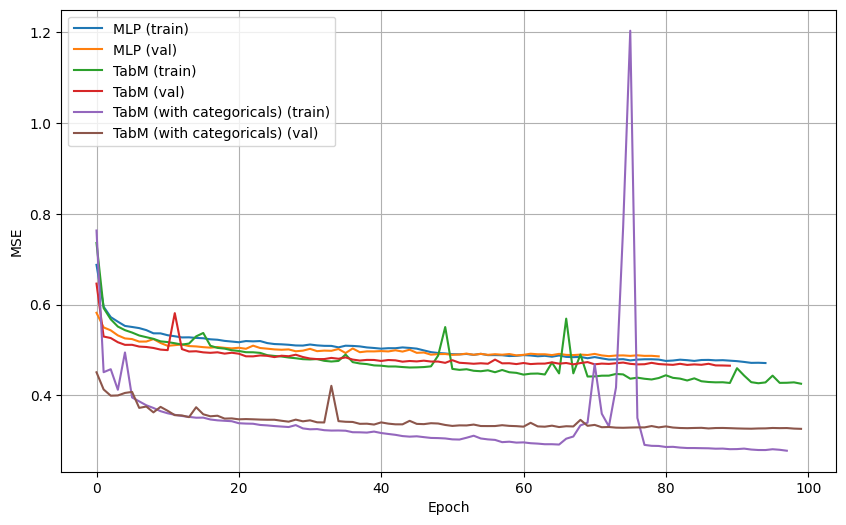

In [77]:
graph_results()

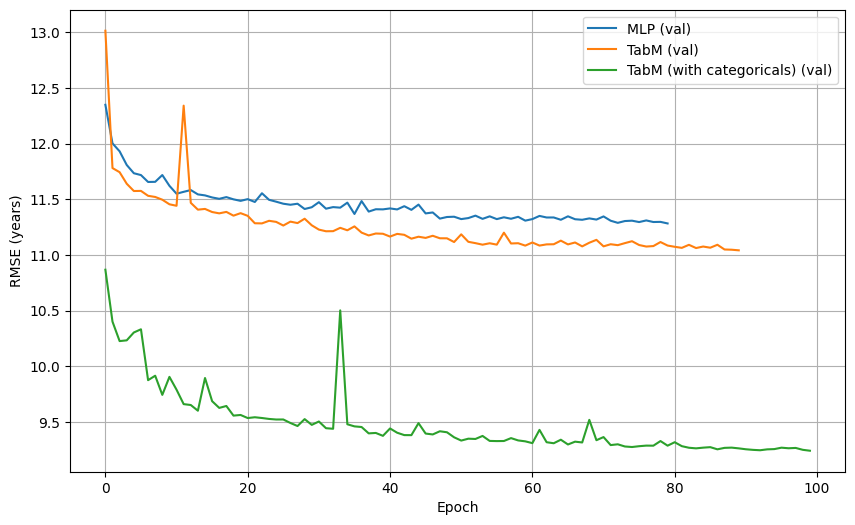

In [81]:
graph_results(splits=['val'], unscale=True)

In [79]:
with open('results.json', 'w') as f:
    json.dump(results, f, indent=4)

In [98]:
best_unscaled = [min(unscale_scores(results[model]['val'])) for model in results.keys()]
best_unscaled

[11.282984991578187, 11.041478198576398, 9.241244515413491]

In [101]:
for i in range(1, len(best_unscaled)):
    print((1 - best_unscaled[i] / best_unscaled[0]) * 100)

2.1404512474496262
18.0957475144094


In [103]:
1 - best_unscaled[2] ** 2 / float(target_pipeline['scaler'].scale_[0] ** 2)

0.6742140948772429